# Compute health expenditures per income level

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats 
from importlib import reload
import pandas as pd
import pickle

In [2]:
from tools import micro
from tools import macro
from tools import params
from tools import distributions as dist
reload(micro)
reload(macro)
reload(params)
reload(dist)

<module 'tools.distributions' from '/Users/flangot/Dropbox/agghealth/notebooks/tools/distributions.py'>

## Model paramters

In [3]:
pars = pd.read_pickle('../output_JPE/pars.pkl')
pars

,de,dk,fr,it,nl,se,sp,us
beta,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000,0.970000
psi,0.161578,0.161578,0.161578,0.161578,0.161578,0.161578,0.161578,0.161578
sigma,2.105317,2.105317,2.105317,2.105317,2.105317,2.105317,2.105317,2.105317
phi,0.397405,0.397405,0.397405,0.397405,0.397405,0.397405,0.397405,0.397405
d1,-1.282523,-1.602088,-1.099845,-0.831846,-1.390736,-1.394792,0.002353,-0.988958
d2,4.029535,4.273080,3.786290,3.917407,3.992196,4.310991,3.434494,3.511651
p,0.836301,0.888409,0.604059,0.695076,0.657280,0.891689,0.642584,1.000000
tfp,1.011023,1.260592,0.922111,0.613212,0.989482,0.795415,0.795095,1.000000


## GE baseline model

In [4]:
countries = pars.columns
scenarios = ['pus_ge']#,'peu_ge','peu_pe','aeu_ge','aeu_pe']
outcomes  = ['m','y','c','k','n','s','csy','ksy','h','g2','g3','g4','tgood','tbad','r','w','tax','oop']
results   = pd.DataFrame(index=outcomes,columns=scenarios)

### Put the value of $\gamma$

In [5]:
gamma = 1

In [6]:
p = pars.loc[:,'us']
theta = params.flexpars(sigma=p['sigma'],beta=p['beta'],
                            phi=p['phi'],psi=p['psi'],delta_h1=p['d1'],
                            delta_h2=p['d2'],eta=0.0,tfp=p['tfp'],price=p['p'])
# option for the numerical solution
ne = 10
m  = 2.5
#op = params.settings(ne=ne,nk=30,maxk=190.0,curv=0.5,nprocs=40)
op = params.settings(ne=ne,nk=100,maxk=190.0,curv=0.5,nprocs=40)
inc = params.incprocess(country='us')
inc.tauchen(ne=ne,m=m)
aux = params.auxpars(country='us',gamma=gamma)  
#Decision rules
csumers = micro.bellman(options=op,flex=theta,aux=aux,inc=inc,rent=5.6e-2)
csumers.compute_cash()
csumers.itervalue()
# distribution
stats = dist.stationary(dp=csumers,nk=500)
stats.blowup()
stats.compute()
# general equilibrium
eq = macro.equilibrium(stats=stats,taxes=False,rent=True)#,inirent=irate)
eq.solve()
aggs = eq.aggregates()
hlth = eq.healthreport()

# saving aggregate outcomes
res = [aggs.M,aggs.Y,aggs.C,aggs.K,aggs.N,p['p']*aggs.M/aggs.Y,(aggs.C+p['p']*aggs.M)/aggs.Y,
       aggs.K/aggs.Y,hlth.pH,hlth.gradient[0],hlth.gradient[1],hlth.gradient[2],hlth.pTransGood,
       hlth.pTransBad,eq.rent,eq.wage,eq.tax,aggs.M*p['p']*aux.copay]
# saving decision rules
size = stats.ne*stats.nh*stats.nk
opt = pd.DataFrame(index=np.arange(0,size),columns=['e','h','k','ps','c','m','kp','v'])
opt.loc[:,'ps'] = eq.stats.probs
for i,s in enumerate(stats.states):
    e,h,k = s
    opt.loc[i,['e','h','k']] = [e,h,k]  
    opt.loc[i,'c'] = eq.stats.optc[e,h,k]
    opt.loc[i,'m'] = eq.stats.optm[e,h,k]
    opt.loc[i,'kp'] = eq.stats.optk[e,h,k]
    opt.loc[i,'v'] = eq.stats.value[e,h,k]

solved bellman equation (iter, diff cons, diff medexp)  250 0.027383992046138173 13.736923340494544
grid for k (nk, maxk)  100 190.0
stationary distribution converged in  482  iterations 
grid for k (nk maxk) 500 190.0
solved bellman equation (iter, diff cons, diff medexp)  167 0.00020903938172978087 0.0007498084676349492
grid for k (nk, maxk)  100 190.0
stationary distribution converged in  250  iterations 
grid for k (nk maxk) 500 190.0
rate =  0.0005 demand =  37.31615558961398 supply =  19.105192901911295  tax =  0.20209548699654836
solved bellman equation (iter, diff cons, diff medexp)  208 0.00013434546729751418 0.0009848555117066837
grid for k (nk, maxk)  100 190.0
stationary distribution converged in  554  iterations 
grid for k (nk maxk) 500 190.0
rate =  0.025927835051546503 demand =  18.988219712657482 supply =  83.32356942374011  tax =  0.20209548699654836
solved bellman equation (iter, diff cons, diff medexp)  161 0.000707707219033793 0.0009733568024188344
grid for k (nk, 

In [7]:
eqs = []
results.loc[:,'pus_ge'] = res
eqs.append(eq)

In [8]:
results.loc['m','pus_ge']

0.5870104753860099

In [9]:
eqs_temp = []
opt_temp = []

In [10]:
eqs_temp = eqs
opt_temp.append(opt)

In [11]:
eqs  = dict(zip(scenarios,eqs_temp))
opts = dict(zip(scenarios,opt_temp))

In [12]:
gridk = eqs['pus_ge'].stats.gridk
ne, nk, nh = eqs['pus_ge'].stats.ne, eqs['pus_ge'].stats.nk, eqs['pus_ge'].stats.nh

In [13]:
ne

10

## Compute Consumption by health status

In [14]:
columns = ['conso']
index   = ['bad','good']
table_c = pd.DataFrame(index=index,columns=columns)

for h in range(nh):
    cond = (opts['pus_ge'].h == h)
    cb   = opts['pus_ge'].loc[cond,'c'] 
    sel  = opts['pus_ge'].loc[cond,['ps','c']]
    sel  = sel.loc[sel['c'].isna()!=True,:]
    sel['ps'] = sel['ps']/sel['ps'].sum()
    sel['ce'] = sel['ps']*sel['c']
    table_c.loc[index[h],columns[0]] = sel['ce'].sum()

table_c

,conso
bad,1.210032
good,2.42205


## Compute the health expenditures per capita for each $(e,h)$

In [15]:
columns = ['0','1','2','3','4','5','6','7','8','9']
index   = ['bad','good']
table_m = pd.DataFrame(index=index,columns=columns)

for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        mb   = opts['pus_ge'].loc[cond,'m'] 
        sel  = opts['pus_ge'].loc[cond,['ps','m']]
        sel  = sel.loc[sel['m'].isna()!=True,:]
        sel['ps'] = sel['ps']/sel['ps'].sum()
        sel['me'] = sel['ps']*sel['m']
        table_m.loc[index[h],columns[e]] = sel['me'].sum()

table_m

,0,1,2,3,4,5,6,7,8,9
bad,0.582016,0.82714,1.523436,3.42949,8.501819,15.175792,18.733521,20.895175,23.002474,24.877703
good,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000021,0.007312,0.08525


## Compute the healht expenditures per capita for each $e$

In [16]:
indexa   = ['all']
table_ma = pd.DataFrame(index=indexa,columns=columns)

for e in range(ne):
    cond = (opts['pus_ge'].e == e)
    sel  = opts['pus_ge'].loc[cond,['ps','m']]
    sel  = sel.loc[sel['m'].isna()!=True,:]
    sel['ps'] = sel['ps']/sel['ps'].sum()
    sel['me'] = sel['ps']*sel['m']
    table_ma.loc['all',columns[e]] = sel['me'].sum()

table_ma

,0,1,2,3,4,5,6,7,8,9
all,0.183721,0.224896,0.318919,0.481516,0.678183,0.690508,0.651866,0.673549,0.723784,0.838569


## Compute the earning distribution

In [17]:
# Find the medium earning
table_ms = pd.DataFrame(index=indexa,columns=columns)

for e in range(ne):
    cond = (opts['pus_ge'].e == e)
    mb   = opts['pus_ge'].loc[cond,'m'] 
    sel  = opts['pus_ge'].loc[cond,['ps','m']]
    sel  = sel.loc[sel['m'].isna()!=True,:]
    sel['me'] = sel['ps'].sum()
    table_ms.loc['all',columns[e]] = sel['me'].sum()

table_ms = table_ms/table_ms.loc['all',:].sum()
table_ms

,0,1,2,3,4,5,6,7,8,9
all,0.01888,0.047328,0.09461,0.15011,0.189071,0.189071,0.15011,0.09461,0.047328,0.01888


In [18]:
table_ms.loc['all',columns[0:5]].sum()

0.4999999999999998

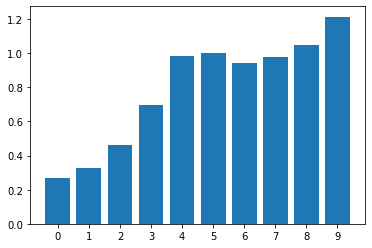

In [19]:
# Health expenditure relative to health expenditures of the median earning worker
plt.bar(columns,table_ma.loc['all',:]/table_ma.loc['all',columns[5]])
plt.show()

## Data from MEPS

In [20]:
# Data from gradient.do
meamD  = np.array([-21.19856, -41.96368, -28.5981, -16.67655, 0, 19.98636, 33.52531, 37.99886, 47.27721, 48.47044])
stdD   = np.array([  5.045355, 3.378933, 2.664207, 2.321089,  0, 2.045838, 2.109012, 2.422832, 3.112756, 4.966065])
meamDS = np.array([-4.125244, -17.44024, -14.93441, -14.83106,0, 5.394649, 13.47662, 19.73705, 24.00138, 17.45952])
stdDS  = np.array([  7.54685,  4.536454, 4.536454, 3.054224,  0, 2.794403, 2.877877, 3.262431, 4.263996, 6.757589])
# Model
meamM = 100*(table_ma.loc['all',:]/table_ma.loc['all',columns[5]] - 1)

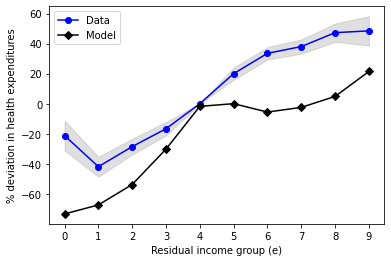

In [21]:
ci = 1.96*stdD

fig, ax = plt.subplots()
ax.plot(columns,meamD,'-o',color='b',label='Data')
ax.fill_between(columns, (meamD-ci), (meamD+ci), color='grey', alpha=.25)
ax.plot(columns,meamM,'-D',color='k',label='Model')
plt.xlabel('Residual income group (e)')
plt.ylabel('% deviation in health expenditures')
plt.legend()
#plt.savefig('/Users/flangot/Dropbox/agghealth/figures_JPE/health_exp_income_all.eps', bbox_inches='tight',dpi=600) 
plt.show()